In [ ]:
import pandas as pd
import numpy as np
import random
import time
import re

import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cpu'

Целью данной работы является реализация нейронной сети, задача которой - генерация клички питомца на основании передаваемого ей набора данных. На вход модели поступают следующие данные: значение пола питомца («female» или «male») и необходимое количество вариантов кличек. На выходе модель выдает указанное ранее количество сгенерированных кличек.

# 1. Первичный анализ данных

Датасет взят с сайта NYC Open Data. Он содержит в себе 616890 строк с данными о зарегистрированных собаках в Нью-Йорке. Из данного датасета для обучения модели понадобятся только две колонки - AnimalName и AnimalGender.

Ссылка на датасет: https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp/about_data

In [ ]:
filename = 'NYC_Dog_Licensing_Dataset_20250107.csv'
df = pd.read_csv(filename, sep=',', na_filter=False)
df.head()

/var/folders/wt/ln3qm_qx66x2xn97lw7_xg_c0000gn/T/ipykernel_19999/4147436092.py:2: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep=',', na_filter=False)


,AnimalName,AnimalGender,AnimalBirthYear,BreedName,ZipCode,LicenseIssuedDate,LicenseExpiredDate,Extract Year
0,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,10035,09/12/2014,09/12/2017,2016
1,YOGI,M,2010,Boxer,10465,09/12/2014,10/02/2017,2016
2,ALI,M,2014,Basenji,10013,09/12/2014,09/12/2019,2016
3,QUEEN,F,2013,Akita Crossbreed,10013,09/12/2014,09/12/2017,2016
4,LOLA,F,2009,Maltese,10028,09/12/2014,10/09/2017,2016


Основные первичные критерии правильности данных:
- для каждой клички указан пол животного (F или M);
- кличка может состоять только из букв английского алфавита и символа пробела.

Для анализа данные приведены к нижнему регистру и удалены дубликаты.

Неподходящие под первичные критерии значения:

In [ ]:
fieldname_name = 'AnimalName'
fieldname_gender = 'AnimalGender'

df = df[[fieldname_name, fieldname_gender]]
df = df.apply(lambda col: col.str.lower())

df_filter = df.loc[df['AnimalName'].str.contains(r'[^a-z ]')]
df_filter = df_filter.drop_duplicates(subset=['AnimalName'])
df_filter

,AnimalName,AnimalGender
8,heidi-bo,f
83,a.j.,m
721,la-ne-na,f
723,lah-lah,f
908,cee-cee,f
...,...,...
610444,amy-rose,f
613346,sanchez-huerta,m
613807,riley-marie,f
613982,choko-latte,f


В данном случае всего 1064 строки из 616890 необходимо очистить от лишних символов (либо в конечном итоге удалить).

Эти строки можно очистить, выполнив следующие действия:

- удалить текст в скобках;
- удалить лишние символы (точку с запятой, скобки, тире, построфы и тд);
- удалить значения n/a;
- удалить клички, которые состоят из букв с грависом (тк аналогичные, с использованием только букв английского алфавита уже имеются в датасете);
- разделить клички, указанные через слеш (добавив при этом новые строки в датафрейм);
- удалить лишние пробелы после обработки;
- удалить клички с количеством слов больше 2;
- удалить клички с длиной мельше 3.

In [ ]:
def get_clear_data(df, fieldname_name, fieldname_gender):

    df = df.loc[df[fieldname_gender].isin(['f', 'm'])]
    df = df.loc[~df[fieldname_name].isnull()]

    # удаление текста в скобках
    df[fieldname_name] = df[fieldname_name].str.replace(r'\([^()]*\)*', '', regex=True)

    # разделение кличек, указанных через слеш
    df[fieldname_name] = df[fieldname_name].str.split('/')
    df = df.explode(fieldname_name)

    # удаление прочих символов
    df[fieldname_name] = df[fieldname_name].str.replace('.', ' ')
    df[fieldname_name] = df[fieldname_name].str.replace('-', ' ')
    df[fieldname_name] = df[fieldname_name].str.replace('_', ' ')
    df[fieldname_name] = df[fieldname_name].str.replace(r'[\'\"”“’‘`]', '', regex=True)
    df[fieldname_name] = df[fieldname_name].str.replace(r'[!)?,]', '', regex=True)
    df[fieldname_name] = df[fieldname_name].str.replace('n/a', '')
    # df[fieldname_name] = df[fieldname_name].str.replace(r'[0-9]', ' ', regex=True)
    df = df.loc[~df[fieldname_name].str.contains(r'[^a-z ]')]

    # удаление лищних пробелов
    df[fieldname_name] = df[fieldname_name].apply(lambda x: ' '.join(x.split()))

    # длина клички > 2 и число слов < 5
    df['len_name'] = df[fieldname_name].apply(lambda x: len(x))
    df['len_words'] = df[fieldname_name].apply(lambda x: len(x.split()))
    df = df.loc[df['len_name'] > 2]
    df = df.loc[df['len_words'] < 3]
    df = df.loc[~((df['len_name'] < 5) & (df['len_words'] > 1))]

    return df

In [ ]:
df_filter = get_clear_data(df, fieldname_name, fieldname_gender)
df_filter.sort_values('len_name')

,AnimalName,AnimalGender,len_name,len_words
307179,max,m,3,1
395687,mia,f,3,1
395649,ida,f,3,1
71314,eva,f,3,1
71316,tim,m,3,1
...,...,...,...,...
169357,piplongfellowbutterfieldfroude,m,30,1
39470,jeffersonbarnardramseydonnelly,m,30,1
478431,piplongfellowbutterfieldfroude,m,30,1
564879,abberannuptothemountain millie,f,30,2


In [ ]:
len(df) - len(df_filter), (len(df) - len(df_filter)) / len(df)

(14562, 0.02360550503331226)

Всего из датасета удалено 14562 строки (примерно 2,4%). Кроме того, после обработки остались строки с довольно длинными кличками, которые либо являются исключением, либо они изначально были некорректно добавлены в датасет. Для понимания, какая длина клички является максимальной, стоит посмотреть на их распределение.

In [ ]:
df_unique = df_filter.drop_duplicates(subset=['AnimalName', 'AnimalGender'])
df_unique = df_unique.reset_index(drop=True)
df_unique.sort_values('len_name')

,AnimalName,AnimalGender,len_name,len_words
20192,rhu,m,3,1
10125,tum,f,3,1
31261,bts,m,3,1
31263,owl,f,3,1
26598,cen,f,3,1
...,...,...,...,...
22166,budereauxbuderonimusbuderowski,m,30,1
15381,piplongfellowbutterfieldfroude,m,30,1
9581,jeffersonbarnardramseydonnelly,m,30,1
35225,abberannuptothemountain millie,f,30,2


In [ ]:
df_unique['len_name'].value_counts()

len_name
5     9278
6     8846
7     5712
4     5547
8     3280
9     1622
3     1434
10     893
11     341
12     170
13      62
14      36
15      23
16       9
30       5
17       5
18       5
19       1
26       1
27       1
23       1
21       1
25       1
20       1
24       1
Name: count, dtype: int64

В данном случае можно ограничиться длиной кличики, равной 15.

In [ ]:
df_unique = df_unique.loc[(df_unique['len_name'] < 16)]
df_unique

,AnimalName,AnimalGender,len_name,len_words
0,paige,f,5,1
1,yogi,m,4,1
2,ali,m,3,1
3,queen,f,5,1
4,lola,f,4,1
...,...,...,...,...
37271,brax,m,4,1
37272,cottonball,m,10,1
37273,oren,f,4,1
37274,cocobear,m,8,1


# 2. Метрика качества

In [ ]:
def test_pets_name(pets_name, print_names=False, print_acc=False):
    acc = 0
    for name in pets_name:
        correct = True
        name = name[1:-1]

        if re.findall(r'[aeiouy]{4,}', name): correct = False
        if re.findall(r'[bcdfghjklmnpqrstvwxz]{4,}', name): correct = False
        if not re.findall(r'[aeiouy]', name): correct = False
        if not re.findall(r'[bcdfghjklmnpqrstvwxz]', name): correct = False
        if re.findall(r'^\s', name): correct = False
        if re.findall(r'\s$', name): correct = False
        if re.findall(r'\s{2,}', name): correct = False
        if re.findall(r'(.)\1\1', name): correct = False
        if len(name) == 3 and len(name.split()) == 2: correct = False
        if len(name) < 3: correct = False
        if len(re.findall(r'\s', name)) > 2: correct = False

        if correct: acc += 1
        if print_names: print(f'\'{name}\' - {correct}')

    acc = acc/len(pets_name)
    if print_acc:
        print(f'accuracy = {acc}')
    else:
        return acc

# 3. Baseline-модель

In [ ]:
def get_pet_name(df, gender, N):
    df = df.loc[df['AnimalGender'] == gender]
    letters = sorted(set(' '.join(df['AnimalName'].values)))
    min_len_name = df['len_name'].min()
    max_len_name = df['len_name'].max()

    pets_name = []
    for i in range(N):
        len_name = random.randint(min_len_name, max_len_name)
        pet_name = '<'
        for i in range(len_name):
            pet_name += random.choice(letters)
        pets_name.append(pet_name + '>')

    return pets_name

**Пример сгенерированных baseline-моделью кличек:**

In [ ]:
N = 10
gender = 'm'

pets_name = get_pet_name(df_unique, gender, N)
print(pets_name)

['<jcuzsjvkw>', '<oaafsymioh>', '<pq aygxfgzv>', '<vzjntehtj>', '<aopd>', '<nxakqvowiapg>', '<sqrzuyrvrw>', '<pekrno>', '<xkpzevfe>', '<hiljgkqa >']


**Оценка качества baseline-модели:**

In [ ]:
N = 100
gender = 'f'
pets_name = get_pet_name(df_unique, gender, N)

test_pets_name(pets_name, print_names=False, print_acc=True)

accuracy = 0.29


# 4. Подготовка данных для обучения

In [ ]:
class PetNamesDataset(Dataset):
    def __init__(self, df, name_field, gender_field):
        super().__init__()
        self.names = df[name_field].values
        self.genders = df[gender_field].values
        self.genders_vocab = list(set(self.genders))
        self.genders_size = len(self.genders_vocab)

        self.vocab = sorted(set(' '.join(self.names))) + ['<', '>']
        self.vocab_size = len(self.vocab)
        self.char_to_index = {c:i for i, c in enumerate(self.vocab)}
        self.index_to_char = {i:c for i, c in enumerate(self.vocab)}

    def __getitem__(self, index):
        line = self.names[index]
        x_str = '<' + line
        y_str = line + '>'

        cat = torch.zeros([1, self.genders_size], dtype=torch.long)
        cat[0][self.genders_vocab.index(self.genders[index])] = 1
        x = torch.zeros([len(x_str), self.vocab_size], dtype=torch.float)
        y = torch.empty(len(x_str), dtype=torch.long)
        for i, (x_ch, y_ch) in enumerate(zip(x_str, y_str)):
            x[i][self.char_to_index[x_ch]] = 1
            y[i] = self.char_to_index[y_ch]

        return cat, x, y

    def __len__(self):
        return len(self.names)

In [ ]:
names_dataset = PetNamesDataset(df_unique, 'AnimalName', 'AnimalGender')
names_dataloader = DataLoader(names_dataset, shuffle=True)
len(names_dataset)

37244

In [ ]:
names_dataset[0]

(tensor([[0, 1]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([16,  1,  9,  7,  5, 28]))

# 5. Эксперементальная часть обучения

Датасет df_result будет хранить результаты экспериментов. Обучение будет длиться 10 эпох.

In [ ]:
hidden_size = 50
learning_rate = 1e-4
max_name_len = df_unique['len_name'].max()

epochs = 10
epochs_print = 2

In [ ]:
df_result = pd.DataFrame(columns=['Model', 'Epochs', 'Train loss', 'Time', 'Test accuracy'])

# добавление в сводную таблицу результатов оценки качества baseline-модели

df_result.loc[len(df_result)] = ['Baseline-model', '', '', '',
                                 test_pets_name(pets_name, print_names=False, print_acc=False)]

Для ускорения процесса проведем обучение эксперементальных моделей на неполном наборе данных (примерно 1/3):

In [ ]:
names_dataset = PetNamesDataset(df_unique[:10000], 'AnimalName', 'AnimalGender')
names_dataloader = DataLoader(names_dataset, shuffle=True)

In [ ]:
def generate_one_name(model, dataset, category, max_name_len, device='cpu'):
    cat = torch.zeros([1, dataset.genders_size], dtype=torch.long, device=device)
    cat[0][dataset.genders_vocab.index(category)] = 1

    end_char_idx = dataset.char_to_index['>']
    start_char_idx = dataset.char_to_index['<']
    pet_name = [start_char_idx]

    model.eval()
    hidden = model.init_hidden(device)

    x = torch.zeros([1, dataset.vocab_size], dtype=torch.float, device=device)
    x[0, start_char_idx] = 1

    for i in range(max_name_len):
        output, hidden = model(cat, x, hidden)

        y_softmax_scores = torch.softmax(output, dim=1)
        for ind in pet_name:
            y_softmax_scores[0][ind] = 0
        y_softmax_scores = y_softmax_scores / y_softmax_scores.sum()

        predicted_char_idx = np.random.choice(
            np.arange(dataset.vocab_size),
            p=y_softmax_scores.detach().numpy().ravel())

        pet_name.append(predicted_char_idx)

        if predicted_char_idx == end_char_idx: break

        x = torch.zeros((1, dataset.vocab_size), dtype=torch.float, device=device)
        x[0][predicted_char_idx] = 1

    return ''.join(dataset.index_to_char[x] for x in pet_name)

In [ ]:
def train_model(model, model_name, criterion, optimizer, dataset, dataloader, max_name_len, epochs=10, epochs_print=1, device='cpu'):
    start = time.time()

    model_loss = 0
    loss_print = {}
    for e in range(1, epochs+1):
        start_epoch = time.time()
        model.train()
        for line, (cat, x, y) in enumerate(dataloader):
            cat, x, y = cat.to(device), x.to(device), y.to(device),
            hidden = model.init_hidden(device)
            optimizer.zero_grad()
            loss = 0

            for i in range(x.shape[1]):
                output, hidden = model(cat[0], x[:, i], hidden)
                loss += criterion(output, y[:, i])

            model_loss = loss.item() / x.shape[1]
            loss.backward()
            optimizer.step()

        model_loss = model_loss / len(dataloader)

        if e % epochs_print == 0:
            loss_print[e] = model_loss
            pets_names = []
            for i in range(5):
                pets_names.append(generate_one_name(model, dataset, random.choice(dataset.genders), max_name_len, device))
            print(f'Epoch: {e}. Loss: {model_loss}. Time: {time.time() - start_epoch}')
            print(pets_names, '\n')

    return (model_name, epochs, model_loss, time.time() - start), loss_print

## 5.1. Простая рекуррентная сеть с разными рекуррентными слоями

В данном разделе обучим 3 нейросети (RNN, GRU и LSTM).

In [ ]:
class BaseRNNModel(nn.Module):
    def __init__(self, rnnClass, input_size, hidden_size, output_size, categories_count, drop=0.1):
        super(BaseRNNModel, self).__init__()
        self.rnnClass = rnnClass
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.categories_count = categories_count

        self.rnn = rnnClass(self.categories_count + self.input_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input = torch.cat((category, input), 1)
        output, hidden = self.rnn(input, hidden)

        output = self.out(output)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self, device):
        hidden = torch.zeros(1, self.hidden_size, device=device)
        if 'LSTM' in str(self.rnnClass): hidden = tuple([hidden, hidden])

        return hidden

In [ ]:
def test_train_base(model_name, class_name, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result):
    model = class_name(model_name, names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    print(model_name, '\n')
    df_result.loc[len(df_result), df_result.columns[:-1]], _ = train_model(model, model_name.__name__, criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

    pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
    df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

    return df_result

In [ ]:
df_result = test_train_base(nn.RNN, BaseRNNModel, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result)

<class 'torch.nn.modules.rnn.RNN'> 

Epoch: 2. Loss: 0.00025342259407043456. Time: 15.24247670173645
['<adeczio>', '<doxyt>', '<>', '<nogeatd>', '<vkih>'] 

Epoch: 4. Loss: 0.00026351470947265625. Time: 15.769515037536621
['<bua>', '<lenaiyu>', '<goslei>', '<algiy>', '<milob>'] 

Epoch: 6. Loss: 0.0002436138470967611. Time: 15.25282907485962
['<oaubnd>', '<bopr>', '<xhiel>', '<wreasin>', '<kaupmrt>'] 

Epoch: 8. Loss: 0.00024292192459106446. Time: 15.393764019012451
['<rizne>', '<soina>', '<dista>', '<voaz>', '<pube>'] 

Epoch: 10. Loss: 0.00020589665004185268. Time: 15.210447072982788
['<cualey>', '<sireuof>', '<bkeyoa>', '<loeir>', '<amr>'] 



In [ ]:
df_result = test_train_base(nn.GRU, BaseRNNModel, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result)

<class 'torch.nn.modules.rnn.GRU'> 

Epoch: 2. Loss: 0.0002798629488263811. Time: 20.40805411338806
['<igqelay>', '<yap>', '<w>', '<epldsynaikug>', '<zl>'] 

Epoch: 4. Loss: 0.0003057645161946615. Time: 20.171867847442627
['<iralf>', '<oeas>', '<cms>', '<ux>', '<ym>'] 

Epoch: 6. Loss: 0.00028279037475585937. Time: 20.233448266983032
['<qerzkan>', '<tihyk>', '<hyaen>', '<vdnhw>', '<heqzg>'] 

Epoch: 8. Loss: 0.0003048119650946723. Time: 21.27648115158081
['<iafk>', '<otsemir>', '<runia>', '<odaly>', '<diegn>'] 

Epoch: 10. Loss: 0.00027655724116734095. Time: 20.862308025360107
['<znvre>', '<ohike>', '<ieabln>', '<pfrhgy>', '<smoea>'] 



In [ ]:
df_result = test_train_base(nn.LSTM, BaseRNNModel, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result)

<class 'torch.nn.modules.rnn.LSTM'> 



Epoch: 2. Loss: 0.000296295166015625. Time: 21.867918014526367
['<e>', '<ynm>', '<>', '<zts>', '<xmuko>'] 

Epoch: 4. Loss: 0.00028983968098958337. Time: 21.75413417816162
['<in>', '<m>', '<ave>', '<ois>', '<en>'] 

Epoch: 6. Loss: 0.00032678933143615724. Time: 21.997129917144775
['<ried>', '<>', '<jzare>', '<sj>', '<aubcr>'] 

Epoch: 8. Loss: 0.00027604519526163736. Time: 21.73138999938965
['<gktsiycr>', '<moye>', '<ero>', '<prls>', '<eoy>'] 

Epoch: 10. Loss: 0.000295546555519104. Time: 22.207648992538452
['<>', '<atou>', '<gdicoa>', '<bulofnie>', '<mral>'] 



In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,Baseline-model,,,,0.37
1,RNN,10,0.000206,153.87147,0.83
2,GRU,10,0.000277,205.352433,0.82
3,LSTM,10,0.000296,219.111894,0.71


Простая рекуррентная сеть (torch.nn.RNN) показала в данном случае лучшие результаты - метрика на тестовых данных составила 0.83, что уже можно считать хорошим результатом по сравнению с baseline-моделью.

## 5.2. Добавление дополнительных слоев для усложнения модели

Для улучшения результата можно изменить архитектуру рекуррентной сети. Для различных экспериментов удобно вместо готовых рекуррентных ячеек torch.nn использовать линейные слои, в которые согласно той или иной архитектуре будут передаваться признаки и скрытые состояния.

In [ ]:
def test_train(class_name, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result):
    model = class_name(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    print(class_name.__name__, '\n')
    df_result.loc[len(df_result), df_result.columns[:-1]], _ = train_model(model, class_name.__name__, criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

    pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
    df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

    return df_result, model

In [ ]:
class RNNLinear_v1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, categories_count):
        super(RNNLinear_v1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.categories_count = categories_count

        self.i2h = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input)
        output = self.i2o(input)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self, device):
        return torch.zeros(1, self.hidden_size, device=device)

In [ ]:
df_result, model = test_train(RNNLinear_v1, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result)

RNNLinear_v1 

Epoch: 2. Loss: 0.0002682645525251116. Time: 9.567900896072388
['<lki>', '<ualsr>', '<esoac>', '<vdjmgnziy>', '<acrlioy>'] 

Epoch: 4. Loss: 0.0002521319580078125. Time: 9.244770050048828
['<gaire>', '<varhs>', '<dinuwc>', '<iakrf>', '<ruie>'] 

Epoch: 6. Loss: 0.0002778871536254883. Time: 9.216722965240479
['<mfcuet>', '<solyae>', '<hol>', '<syri>', '<teosnu>'] 

Epoch: 8. Loss: 0.00024700625283377516. Time: 9.199079275131226
['<aoblhiy>', '< elt>', '<jolyea>', '<ions>', '<tauslg>'] 

Epoch: 10. Loss: 0.00023022422790527344. Time: 9.590569257736206
['<irnd>', '<comay>', '<noa>', '<nhalmoed>', '<hegsn>'] 



In [ ]:
class RNNLinear_v2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, categories_count):
        super(RNNLinear_v2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.categories_count = categories_count

        self.init_h = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.hidden_size)
        self.init_o = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.output_size)
        self.out = nn.Linear(self.hidden_size + self.output_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input = torch.cat((category, input, hidden), 1)

        hidden = self.init_h(input)
        output = self.init_o(input)

        output = torch.cat((hidden, output), 1)
        output = self.out(output)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self, device):
        return torch.zeros(1, self.hidden_size, device=device)

In [ ]:
df_result, model = test_train(RNNLinear_v2, names_dataset, names_dataloader, hidden_size, learning_rate, device, max_name_len, epochs, epochs_print, df_result)

RNNLinear_v2 

Epoch: 2. Loss: 0.0002563673291887556. Time: 12.099187850952148
['<nvfial>', '<tuda>', '<atr>', '<ecs>', '<qubnt>'] 

Epoch: 4. Loss: 0.0002522024472554525. Time: 12.02797794342041
['<nais>', '<sofdienl>', '<ouli>', '<sorith>', '<fnzkbgps>'] 

Epoch: 6. Loss: 0.0002525981630597796. Time: 12.114759922027588
['<jeadin>', '<eirznl>', '<iatndse>', '<ceyli>', '<mica>'] 

Epoch: 8. Loss: 0.00024168979644775392. Time: 12.390651226043701
['<bio>', '<manis>', '<fincl>', '<bszjth>', '<kbai>'] 

Epoch: 10. Loss: 0.00023237616221110025. Time: 12.740334033966064
['<vaft>', '<ftla>', '<ueld>', '<harck>', '<noei>'] 



In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,Baseline-model,,,,0.37
1,RNN,10,0.000206,153.87147,0.83
2,GRU,10,0.000277,205.352433,0.82
3,LSTM,10,0.000296,219.111894,0.71
4,RNNLinear_v1,10,0.00023,93.317316,0.81
5,RNNLinear_v2,10,0.000232,123.303223,0.94


Метрика качества у последнего варианта RNN-модели получилась достаточно высокой. Именно на этой модели и будет осуществляться полноценное обучение.

# 6. Обучение итоговой модели

В данном разделе модель уже будет обучаться на всех данных (37244 строк). Для начала обучение будет длиться 40 эпох, все остальные параметры останутся пока неизменными. В дальнейшем, при необходимости, можно провести еще несколько экспериментов:

1. Добавление дополнительных слоев (например, Dropout).
2. Использование другого оптимизатора.
3. Использование другой функции потерь.
4. Изменение скорости обучения.
5. Изменение количества эпох.

Дополнительно в функцию train_model добавлено вычисление метрики качества на тестовых данных на этапе вывода результатов обучения.

In [ ]:
df_result = pd.DataFrame(columns=['Model', 'Epochs', 'Train loss', 'Time', 'Test accuracy'])

In [ ]:
hidden_size = 50
learning_rate = 1e-4
max_name_len = df_unique['len_name'].max()

epochs = 40
epochs_print = 2

In [ ]:
names_dataset = PetNamesDataset(df_unique, 'AnimalName', 'AnimalGender')
names_dataloader = DataLoader(names_dataset, shuffle=True)
len(names_dataset)

37244

In [ ]:
def train_model(model, model_name, criterion, optimizer, dataset, dataloader, max_name_len, epochs=10, epochs_print=1, device='cpu'):
    start = time.time()

    model_loss = 0
    loss_print, acc_print = {}, {}
    for e in range(1, epochs+1):
        start_epoch = time.time()
        model.train()
        for line, (cat, x, y) in enumerate(dataloader):
            cat, x, y = cat.to(device), x.to(device), y.to(device),
            hidden = model.init_hidden(device)
            optimizer.zero_grad()
            loss = 0

            for i in range(x.shape[1]):
                output, hidden = model(cat[0], x[:, i], hidden)
                loss += criterion(output, y[:, i])

            model_loss = loss.item() / x.shape[1]
            loss.backward()
            optimizer.step()

        model_loss = model_loss / len(dataloader)

        if e % epochs_print == 0:
            loss_print[e] = model_loss
            pets_names = []
            for i in range(5):
                pets_names.append(generate_one_name(model, dataset, random.choice(dataset.genders), max_name_len, device))

            test_names = [generate_one_name(model, dataset, random.choice(dataset.genders), max_name_len, device) for i in range(100)]
            test_acc = test_pets_name(test_names, print_names=False, print_acc=False)
            acc_print[e] = test_acc

            print(f'Epoch: {e}. Loss: {model_loss}. Accuracy: {test_acc}. Time: {time.time() - start_epoch}')
            print(pets_names, '\n')

    return (model_name, epochs, model_loss, time.time() - start), loss_print, acc_print

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, categories_count):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.categories_count = categories_count

        self.init_h = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.hidden_size)
        self.init_o = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.output_size)
        self.out = nn.Linear(self.hidden_size + self.output_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input = torch.cat((category, input, hidden), 1)

        hidden = self.init_h(input)
        output = self.init_o(input)

        output = torch.cat((hidden, output), 1)
        output = self.out(output)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self, device):
        return torch.zeros(1, self.hidden_size, device=device)

In [ ]:
model = RNNModel(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__, criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print, device=device)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 6.273399059332469e-05. Accuracy: 0.81. Time: 47.9957058429718
['<paly>', '<bsne>', '<menga>', '<kaxli>', '<capi>'] 

Epoch: 4. Loss: 8.942056401256536e-05. Accuracy: 0.91. Time: 47.15560293197632
['<olkes>', '<irbes>', '<hdelo>', '<lih>', '<sirlo>'] 

Epoch: 6. Loss: 6.083852259031246e-05. Accuracy: 0.95. Time: 48.108388900756836
['<pus>', '<fopki>', '<sera>', '<podher>', '<jridy>'] 

Epoch: 8. Loss: 8.174507846613087e-05. Accuracy: 0.98. Time: 46.81640291213989
['<bisary>', '<carpts>', '<candie>', '<lamor>', '<senli>'] 

Epoch: 10. Loss: 7.94658265530186e-05. Accuracy: 1.0. Time: 46.98109006881714
['<lensry>', '<etona>', '<rischa>', '<danye>', '<pangbo>'] 

Epoch: 12. Loss: 6.85395075641291e-05. Accuracy: 0.96. Time: 46.81837224960327
['<bolze>', '<sai>', '<gakdo>', '<ctorin>', '<auno>'] 

Epoch: 14. Loss: 6.215875917724964e-05. Accuracy: 0.99. Time: 46.8684618473053
['<niar>', '<kanew>', '<lef>', '<gatru>', '<budsel>'] 

Epoch: 16. Loss: 6.349741794463863e-05. Accurac

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0


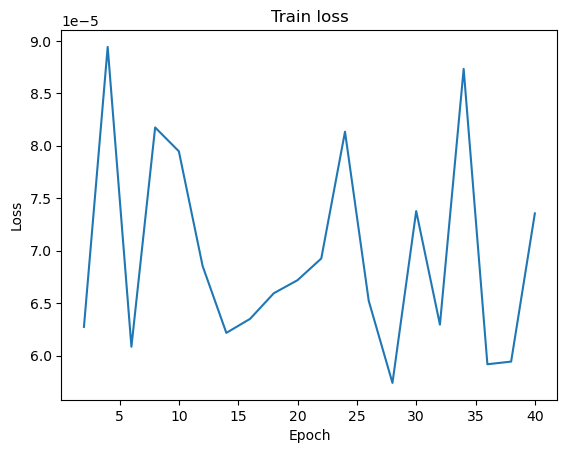

In [ ]:
plt.plot(train_loss.keys(), train_loss.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train loss')
plt.show()

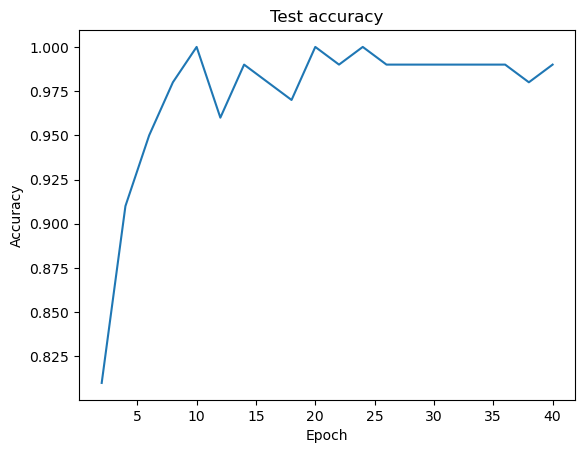

In [ ]:
plt.plot(train_loss.keys(), test_acc.values())
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.show()

## 6.1. Добавление слоя Dropout

In [ ]:
class RNNModel_Dropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, categories_count, drop=0.2):
        super(RNNModel_Dropout, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.categories_count = categories_count

        self.init_h = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.hidden_size)
        self.init_o = nn.Linear(self.categories_count + self.input_size + self.hidden_size, self.output_size)
        self.out = nn.Linear(self.hidden_size + self.output_size, self.output_size)
        self.dropout = nn.Dropout(drop)
        self.softmax = nn.LogSoftmax(dim=1) 

    def forward(self, category, input, hidden):
        input = torch.cat((category, input, hidden), 1)

        hidden = self.init_h(input)
        output = self.init_o(input)

        output = torch.cat((hidden, output), 1)
        output = self.dropout(output)
        output = self.out(output)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self, device):
        return torch.zeros(1, self.hidden_size, device=device)

In [ ]:
model = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (drop=0.2)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 6.978548000285028e-05. Accuracy: 0.83. Time: 53.23875403404236
['<saz ieh>', '<oihnmk>', '<dably>', '<neritasy>', '<fumnqa>'] 

Epoch: 4. Loss: 6.358137756550867e-05. Accuracy: 0.93. Time: 52.39021420478821
['<chin>', '<mbrka>', '<mcxiel>', '<punla>', '<kulronpy>'] 

Epoch: 6. Loss: 6.815798776337727e-05. Accuracy: 0.96. Time: 51.72907304763794
['<pausol>', '<pin esyo>', '<marspouxte>', '<nivak>', '<bukore>'] 

Epoch: 8. Loss: 6.752315434442805e-05. Accuracy: 0.97. Time: 52.67322516441345
['<wochle>', '<chamblie>', '<kanbedi>', '<irlon>', '<vecnu>'] 

Epoch: 10. Loss: 5.556662373813698e-05. Accuracy: 0.96. Time: 52.10756778717041
['<prghom>', '<beriph>', '<qipas>', '<blay>', '<dyues>'] 

Epoch: 12. Loss: 6.178089180493873e-05. Accuracy: 0.97. Time: 52.7323100566864
['<laite>', '<judey>', '<eloin>', '<buro>', '<jalein>'] 

Epoch: 14. Loss: 7.941699568304259e-05. Accuracy: 0.97. Time: 54.05173397064209
['<matsi>', '<mofgi>', '<eruo>', '<cerxais>', '<toucy>'] 

Epoch: 16. 

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97


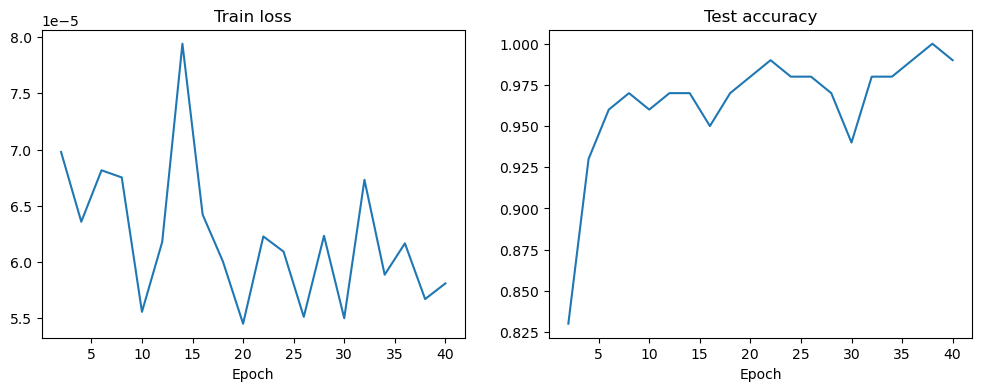

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
model = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (drop=0.5)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 9.266378390214174e-05. Accuracy: 0.79. Time: 52.339441776275635
['<lienkay>', '<mercdy>', '<csbilenk>', '<manc>', '<jgsihp>'] 

Epoch: 4. Loss: 6.763012500624052e-05. Accuracy: 0.91. Time: 51.788777112960815
['<turaney>', '<hotmean>', '<teyvim>', '<>', '<sroniu>'] 

Epoch: 6. Loss: 6.518001882106325e-05. Accuracy: 0.94. Time: 51.47011995315552
['<letdiy>', '<thima>', '<kondi>', '<tuibe>', '<terla>'] 

Epoch: 8. Loss: 5.569108654988148e-05. Accuracy: 0.96. Time: 51.955981731414795
['<lenbcu>', '<galpe>', '<ywdi>', '<depiark>', '<toskel>'] 

Epoch: 10. Loss: 8.060237123985593e-05. Accuracy: 0.98. Time: 52.019246101379395
['<wlemnai y>', '<vadumen>', '<gnyrdlape>', '<me bindurwy>', '<shiwl>'] 

Epoch: 12. Loss: 6.84744552174201e-05. Accuracy: 0.96. Time: 52.00345587730408
['<nisha>', '<ratcil>', '<dorags>', '<bary>', '<curita>'] 

Epoch: 14. Loss: 5.469265700419377e-05. Accuracy: 0.98. Time: 52.286683320999146
['<pagke>', '<fan>', '<mdowus>', '<diwre>', '<darkfetn>'] 

Epo

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98


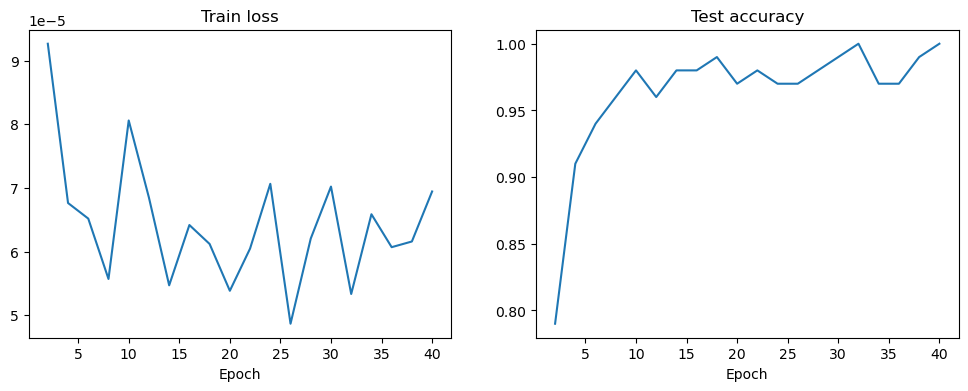

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

Добавление слоя Dropout по идее должно снизить вероятность переобучения модели, в случае задачи генерации новых кличек это важно, потому что модель должна скорее научиться закономерностям построения кличек (правилам), а не просто дублировать уже имещиеся из набора данных.

Train loss при добавлении слоя Dropout в случае 40 эпох уменьшается заметнее, чем в изначальном варианте, а график Test Accuracy немного более гладкий. Дальнейшие эксперименты можно проводить используя 2 варианта RNN-модели - со слоем Dropout и без него.

## 6.2. Использование оптимизатора Adam

In [ ]:
model = RNNModel(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (Adam)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 6.807854833388838e-05. Accuracy: 0.98. Time: 64.35667681694031
['<caevin>', '<chin>', '<stid>', '<goad>', '<waromi>'] 

Epoch: 4. Loss: 6.694314098552761e-05. Accuracy: 0.99. Time: 64.97548699378967
['<iahue>', '<rashio>', '<mayfko>', '<kichordy>', '<avon>'] 

Epoch: 6. Loss: 7.61290931148568e-05. Accuracy: 1.0. Time: 71.40609192848206
['<yumied>', '<geksibulfy>', '<suckoy>', '<scole>', '<olyu>'] 

Epoch: 8. Loss: 6.198271497152112e-05. Accuracy: 0.99. Time: 83.48323726654053
['<apelo>', '<krdon>', '<nilamed>', '<fbet>', '<bageru>'] 

Epoch: 10. Loss: 7.019835222088781e-05. Accuracy: 0.98. Time: 77.63418912887573
['<kizhoe>', '<dambi>', '<frinkablo>', '<siruke>', '<arglis>'] 

Epoch: 12. Loss: 5.7138557811004114e-05. Accuracy: 0.98. Time: 80.14419102668762
['<chanite>', '<rems>', '<phmiltaron>', '<flokvy>', '<kamied>'] 

Epoch: 14. Loss: 6.1027282368239315e-05. Accuracy: 0.99. Time: 87.01045417785645
['<oudise>', '<miro>', '<nertom>', '<eas>', '<monges>'] 

Epoch: 16. L

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0


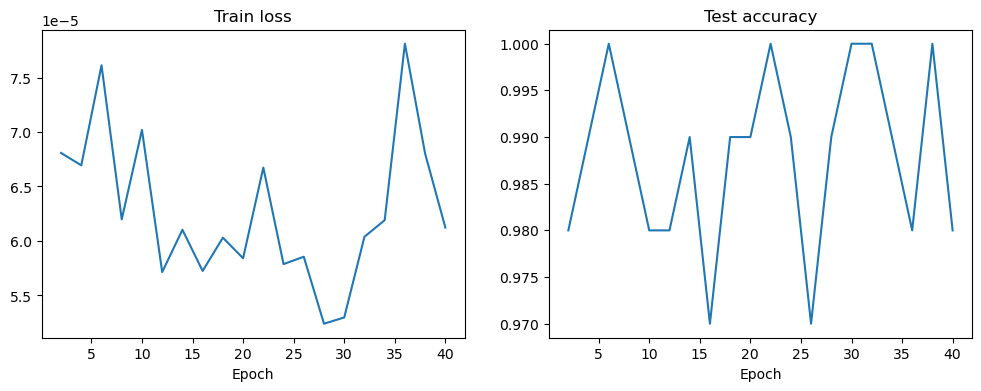

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
model = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (Adam)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 7.198552109221871e-05. Accuracy: 0.95. Time: 79.99462413787842
['<luconik>', '<yailo>', '<lowina>', '<fetra>', '<frocha>'] 

Epoch: 4. Loss: 6.24629534759374e-05. Accuracy: 0.98. Time: 82.43247389793396
['<sidorn>', '<>', '<lyesan>', '<riglon>', '<motisuba>'] 

Epoch: 6. Loss: 5.773202444221366e-05. Accuracy: 0.97. Time: 91.33924627304077
['<namprest>', '<chupfer>', '<cimby>', '<mkeszona>', '<tinus>'] 

Epoch: 8. Loss: 5.9487454101597465e-05. Accuracy: 0.95. Time: 85.99546980857849
['<mor>', '<oranictey>', '<mushen>', '<proesk>', '<ina>'] 

Epoch: 10. Loss: 6.466186874958309e-05. Accuracy: 0.98. Time: 88.74759602546692
['<dacbe>', '<bucki>', '<aphe>', '<miaber>', '<fyre>'] 

Epoch: 12. Loss: 6.6955835219293e-05. Accuracy: 0.97. Time: 94.0701949596405
['<caitouk>', '<fingeltor>', '<curin>', '<erzin>', '<bongeari>'] 

Epoch: 14. Loss: 5.599854227562916e-05. Accuracy: 0.99. Time: 72.36388611793518
['<vikgroud>', '<iav>', '<hondi>', '<nowyim>', '<zalnshy>'] 

Epoch: 16. Los

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0


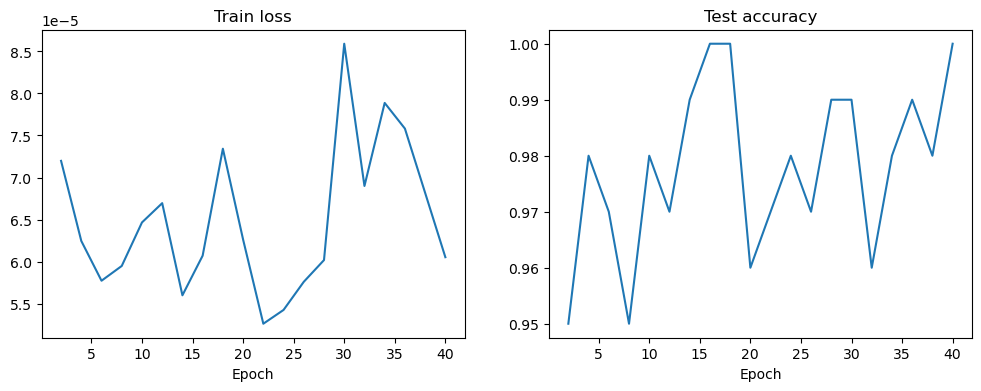

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

## 6.3. Использование функции потерь NLLLoss

In [ ]:
model = RNNModel(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (NLLLoss)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 8.815669716396748e-05. Accuracy: 0.87. Time: 47.8867871761322
['<kebt>', '<eincy>', '<fatsy>', '<tgea>', '<kudbo>'] 

Epoch: 4. Loss: 6.979996879882725e-05. Accuracy: 0.89. Time: 46.30733919143677
['<qherdias>', '<ucotey>', '<mcyaj>', '<wbkmo>', '<dohcre>'] 

Epoch: 6. Loss: 5.894580663548201e-05. Accuracy: 0.99. Time: 47.135401010513306
['<monkaw>', '<yafout>', '<raugio>', '<ulra>', '<tadiero>'] 

Epoch: 8. Loss: 6.970363004171848e-05. Accuracy: 0.97. Time: 47.622090339660645
['<sae>', '<mejnos>', '<monie>', '<lorwiet>', '<bleyk>'] 

Epoch: 10. Loss: 5.5738318256724835e-05. Accuracy: 0.98. Time: 45.935579776763916
['<berdil>', '<rastemi>', '<lechonma>', '<tuanbe>', '<shinegl>'] 

Epoch: 12. Loss: 4.949378680496617e-05. Accuracy: 0.97. Time: 46.90618705749512
['<uranilo>', '<arzie>', '<anberuc>', '<kuawoe>', '<fegon>'] 

Epoch: 14. Loss: 6.963233406952661e-05. Accuracy: 0.99. Time: 46.274008989334106
['<irat>', '<paly>', '<warlien>', '<relfnago>', '<lacku>'] 

Epoch: 16

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0
5,RNNModel (NLLLoss),40,0.000089,1838.172887,0.95


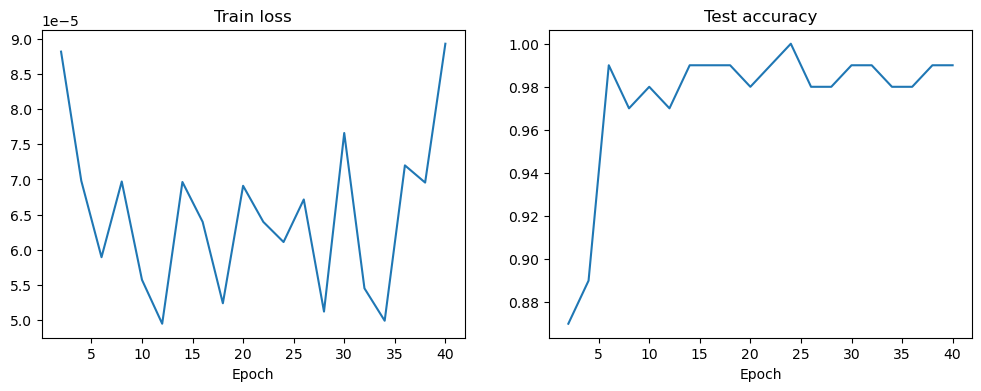

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
model = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.5).to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (NLLLoss)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 7.032059583560491e-05. Accuracy: 0.85. Time: 50.85685682296753
['<dirsanvy>', '<fabey>', '<deniu>', '<boha>', '<muichpl>'] 

Epoch: 4. Loss: 8.56954808493205e-05. Accuracy: 0.92. Time: 49.30042791366577
['<kyso>', '<bre>', '<miyke>', '<bauo>', '< alen>'] 

Epoch: 6. Loss: 7.105505274842053e-05. Accuracy: 0.98. Time: 49.61401891708374
['<vansr>', '<wamoul>', '<apoi>', '<aseu>', '<diuypo>'] 

Epoch: 8. Loss: 6.956378079725068e-05. Accuracy: 0.95. Time: 50.000903844833374
['<ceugwos>', '<dazl>', '<phuabe>', '<fole>', '<sinbky>'] 

Epoch: 10. Loss: 6.70495369728571e-05. Accuracy: 0.98. Time: 49.51948118209839
['<isluta>', '<bakey>', '<tkiymo>', '<elibs>', '<chzily>'] 

Epoch: 12. Loss: 6.973750352372982e-05. Accuracy: 1.0. Time: 51.66207480430603
['<barins>', '<mex hla>', '<yneim>', '<tel>', '<ytazni>'] 

Epoch: 14. Loss: 6.0642435194508577e-05. Accuracy: 0.97. Time: 49.72632026672363
['<bayter>', '<jumo>', '<dielar>', '<bume>', '<ehbay>'] 

Epoch: 16. Loss: 7.4870208485519

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0
5,RNNModel (NLLLoss),40,0.000089,1838.172887,0.95
6,RNNModel_Dropout (NLLLoss),40,0.000076,1998.322957,1.0


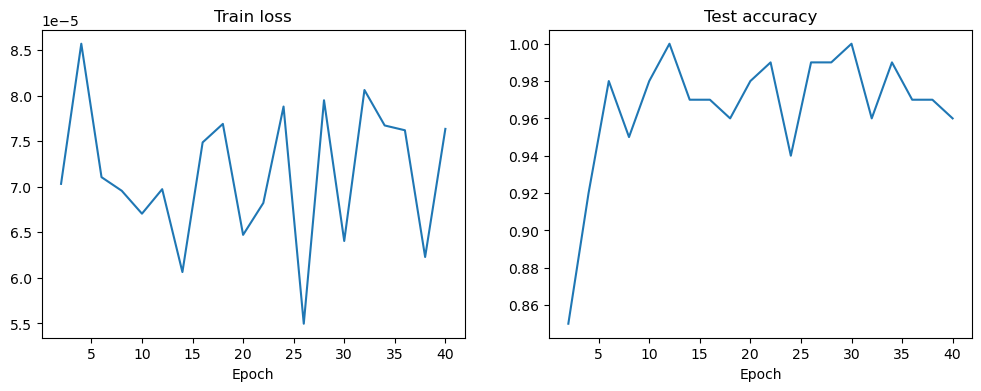

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

## 6.4. Изменение скорости обучения


In [ ]:
learning_rate = 1e-3

In [ ]:
model = RNNModel(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (lr=1e-3)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print, device=device)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 6.174747581892997e-05. Accuracy: 0.98. Time: 46.81344819068909
['<hatylei>', '<jorie >', '<valboshi>', '<gizel>', '<vetaif>'] 

Epoch: 4. Loss: 7.440104877355978e-05. Accuracy: 0.99. Time: 46.692888021469116
['<karsi>', '<kritzungelad>', '<ckabroles>', '<khare>', '<modsi>'] 

Epoch: 6. Loss: 6.533587229669424e-05. Accuracy: 0.97. Time: 47.15199899673462
['<begla>', '<ahi>', '<ckag>', '<ber>', '<mado necki>'] 

Epoch: 8. Loss: 6.589985805376683e-05. Accuracy: 0.97. Time: 46.21047401428223
['<bigoe>', '<chagbor>', '<bhine>', '<jarto>', '<dlambfes>'] 

Epoch: 10. Loss: 5.951833020441496e-05. Accuracy: 0.93. Time: 46.94016098976135
['<bamfindge>', '<cerli>', '<donbila>', '<yave>', '<jargyle>'] 

Epoch: 12. Loss: 5.774498936924284e-05. Accuracy: 1.0. Time: 46.16986107826233
['<medto>', '<tably>', '<fond>', '<semfa>', '<cale>'] 

Epoch: 14. Loss: 6.612263982919841e-05. Accuracy: 0.97. Time: 46.53076934814453
['<lakie>', '<sonfy>', '<sa ryn>', '<tarose>', '<fand>'] 

Epoch: 16

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0
5,RNNModel (NLLLoss),40,0.000089,1838.172887,0.95
6,RNNModel_Dropout (NLLLoss),40,0.000076,1998.322957,1.0
7,RNNModel (lr=1e-3),40,0.000071,1859.413833,1.0


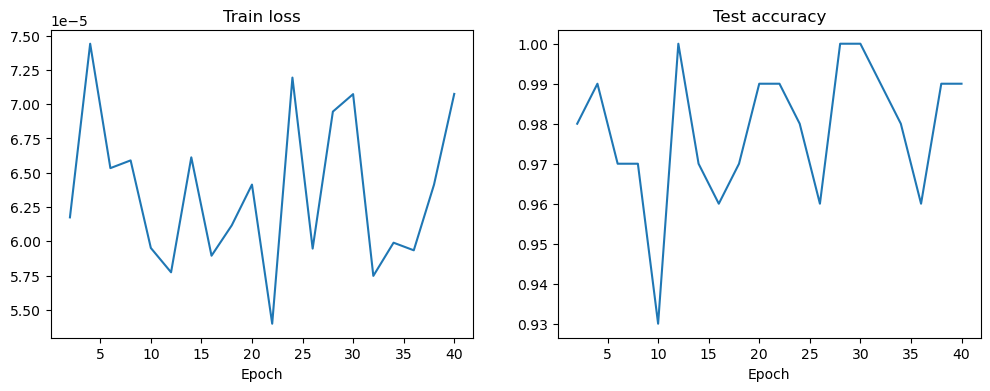

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
model = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (lr=1e-3)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 8.018949938762007e-05. Accuracy: 0.52. Time: 52.18943786621094
['<dyunpre>', '<sekcga>', '<nas>', '<bzni>', '<fnieo>'] 

Epoch: 4. Loss: 7.705323991740835e-05. Accuracy: 0.68. Time: 51.375449895858765
['<a>', '<cgo>', '<h>', '<nekiy>', '<fmaril>'] 

Epoch: 6. Loss: 7.883026346127389e-05. Accuracy: 0.71. Time: 50.629749059677124
['<zony>', '<utebs>', '<hoeri>', '<ocseit>', '<xiemrya>'] 

Epoch: 8. Loss: 6.942383075409003e-05. Accuracy: 0.73. Time: 50.13435697555542
['<nceiyro>', '<bvgny>', '<lutmh>', '<g ynl>', '<npu>'] 

Epoch: 10. Loss: 6.597330372066163e-05. Accuracy: 0.8. Time: 50.09702396392822
['< achr>', '<bmqast>', '<phn>', '<eyungtho>', '<zsae>'] 

Epoch: 12. Loss: 6.29561566025481e-05. Accuracy: 0.76. Time: 50.14388394355774
['<ripth>', '<ikajo>', '<lmaoie>', '<yonzu>', '<yldi>'] 

Epoch: 14. Loss: 8.832788687619855e-05. Accuracy: 0.84. Time: 50.20328116416931
['<paesm>', '<hitl>', '<kornt>', '<cdau>', '<thsicm>'] 

Epoch: 16. Loss: 9.326030406310726e-05. Accur

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0
5,RNNModel (NLLLoss),40,0.000089,1838.172887,0.95
6,RNNModel_Dropout (NLLLoss),40,0.000076,1998.322957,1.0
7,RNNModel (lr=1e-3),40,0.000071,1859.413833,1.0
8,RNNModel_Dropout (lr=1e-3),40,0.000058,2041.635227,0.91


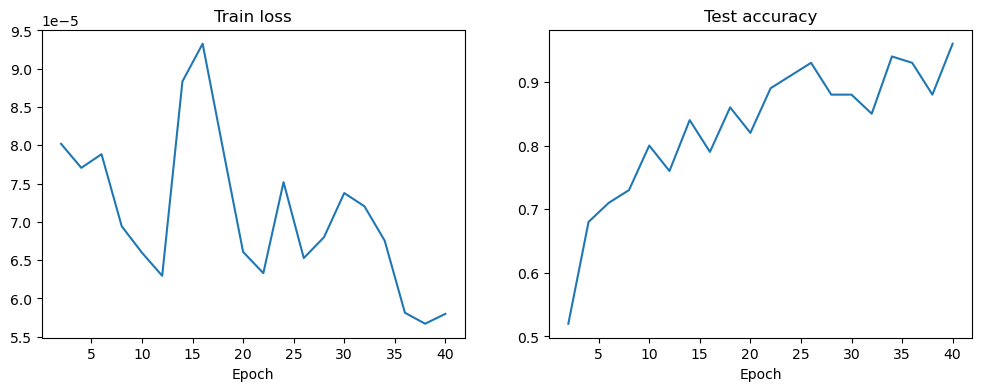

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
learning_rate = 1e-5

In [ ]:
model = RNNModel(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (lr=1e-5)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print, device=device)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 8.027824897863074e-05. Accuracy: 0.49. Time: 45.79617476463318
['<mreb>', '<vai>', '<atl>', '<zda>', '<iant>'] 

Epoch: 4. Loss: 7.289116515665344e-05. Accuracy: 0.72. Time: 47.1084201335907
['<zjty>', '<dioanylc>', '<dwh>', '<zel>', '<lsmxk>'] 

Epoch: 6. Loss: 9.158970961162579e-05. Accuracy: 0.74. Time: 46.9635751247406
['<enpalo>', '<ikslco>', '<zeilcn>', '<rsonke>', '<lpunew>'] 

Epoch: 8. Loss: 7.05394763764673e-05. Accuracy: 0.75. Time: 48.63326287269592
['<mcaehos>', '<jcgir>', '<oiuyfa>', '<yhctaei>', '<gonsah>'] 

Epoch: 10. Loss: 7.678327825704203e-05. Accuracy: 0.64. Time: 46.096680879592896
['<dneatr>', '<gnlb>', '<via>', '< oln>', '<jreqlon>'] 

Epoch: 12. Loss: 7.124850820093669e-05. Accuracy: 0.8. Time: 46.00141406059265
['<eano>', '<hraiek>', '<ntkcs>', '<uediyaz>', '<zstr>'] 

Epoch: 14. Loss: 6.536218929089337e-05. Accuracy: 0.82. Time: 45.66371297836304
['<calnk>', '<moiay>', '<yisluca>', '<lasyeid>', '<saprcnwel>'] 

Epoch: 16. Loss: 8.2000478558150

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0
5,RNNModel (NLLLoss),40,0.000089,1838.172887,0.95
6,RNNModel_Dropout (NLLLoss),40,0.000076,1998.322957,1.0
7,RNNModel (lr=1e-3),40,0.000071,1859.413833,1.0
8,RNNModel_Dropout (lr=1e-3),40,0.000058,2041.635227,0.91
9,RNNModel (lr=1e-5),40,0.00006,1850.441147,0.92


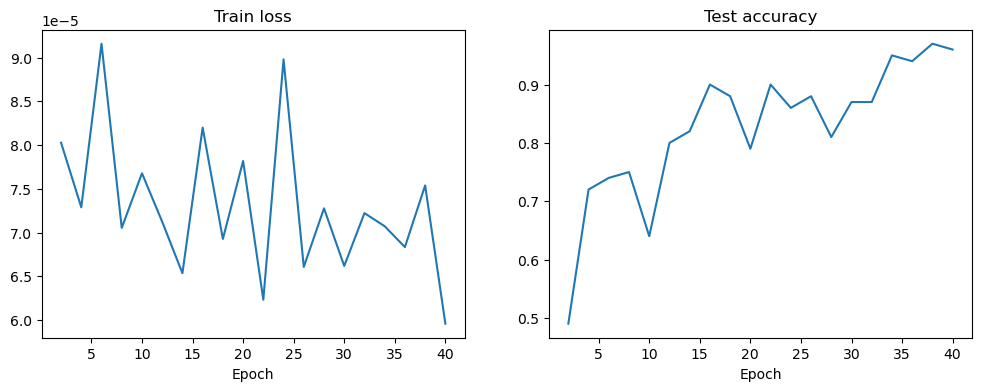

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
model = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

df_result.loc[len(df_result), df_result.columns[:-1]], train_loss, test_acc = train_model(model, model.__class__.__name__ + ' (lr=1e-5)', criterion, optimizer,
                                                   names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
df_result.loc[len(df_result)-1, df_result.columns[-1]] = test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 7.578414667691007e-05. Accuracy: 0.62. Time: 52.01409602165222
['<z rteb>', '<ilg>', '<o>', '<aomw>', '<thnr k>'] 

Epoch: 4. Loss: 8.873078636420989e-05. Accuracy: 0.6. Time: 51.09957790374756
['<ieqrl>', '<ahnl>', '<geh>', '<>', '<naliftb>'] 

Epoch: 6. Loss: 8.352747563708419e-05. Accuracy: 0.69. Time: 52.36677408218384
['<raiel>', '<ioemnsd>', '<gwliabt>', '<w>', '<hnlfa>'] 

Epoch: 8. Loss: 8.011911182300262e-05. Accuracy: 0.72. Time: 52.37792897224426
['<zuoblt>', '<jiesbtnoyh>', '<puohec>', '<nadoetk>', '<ugtch>'] 

Epoch: 10. Loss: 6.641296810931674e-05. Accuracy: 0.75. Time: 53.99169921875
['<ialn>', '<oqrny>', '<oira>', '< lorhu>', '<teaniy>'] 

Epoch: 12. Loss: 7.149829809192735e-05. Accuracy: 0.79. Time: 54.19748902320862
['<hopy>', '<cabe>', '<panf>', '<sjnrk>', '<olnme>'] 

Epoch: 14. Loss: 7.053269278701906e-05. Accuracy: 0.77. Time: 50.83813691139221
['<>', '<rtam>', '<cakue>', '<peryolga>', '<alxo>'] 

Epoch: 16. Loss: 7.478018468522645e-05. Accuracy: 0

In [ ]:
df_result

,Model,Epochs,Train loss,Time,Test accuracy
0,RNNModel,40,0.000074,1894.816932,1.0
1,RNNModel_Dropout (drop=0.2),40,0.000058,2104.176277,0.97
2,RNNModel_Dropout (drop=0.5),40,0.000069,2084.027942,0.98
3,RNNModel (Adam),40,0.000061,3088.182912,1.0
4,RNNModel_Dropout (Adam),40,0.000061,3301.221426,1.0
5,RNNModel (NLLLoss),40,0.000089,1838.172887,0.95
6,RNNModel_Dropout (NLLLoss),40,0.000076,1998.322957,1.0
7,RNNModel (lr=1e-3),40,0.000071,1859.413833,1.0
8,RNNModel_Dropout (lr=1e-3),40,0.000058,2041.635227,0.91
9,RNNModel (lr=1e-5),40,0.00006,1850.441147,0.92


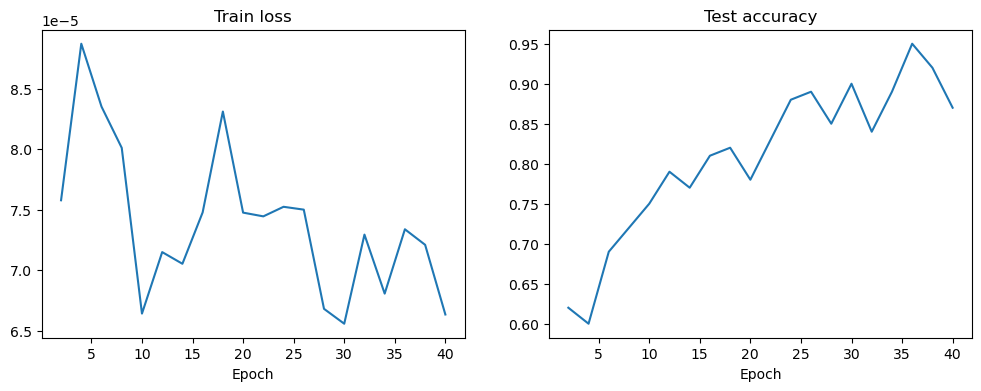

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss.keys(), train_loss.values())
ax[1].plot(train_loss.keys(), test_acc.values())
ax[0].set_title('Train loss')
ax[1].set_title('Test accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
plt.show()

## 6.5. Результаты

Лучшие показатели получились у изначального варианта итоговой RNN-модели и у варианта RNN-модели со слоем Dropout. Эти две модели обучены заново на 50 эпохах.

In [ ]:
epochs = 50
epochs_print = 2
learning_rate = 1e-4

Итоговая RNN-модель без вненсения изменений:

In [ ]:
model_v1 = RNNModel(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_v1.parameters(), lr=learning_rate)
train_model(model_v1, '', criterion, optimizer, names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model_v1, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 7.292340667531231e-05. Accuracy: 0.9. Time: 45.83901619911194
['<koiec>', '<peld>', '<dioayne>', '<fuseglo>', '<dant>'] 

Epoch: 4. Loss: 6.539327170587408e-05. Accuracy: 0.94. Time: 46.18445110321045
['<nha ielv>', '<gami>', '<mosce>', '<brkpen >', '<ronay>'] 

Epoch: 6. Loss: 9.280125218393803e-05. Accuracy: 0.97. Time: 47.393441915512085
['<lasge>', '<guabsi>', '<rekinsa>', '<rabuito>', '<tayne>'] 

Epoch: 8. Loss: 5.488776197854436e-05. Accuracy: 0.95. Time: 47.13308310508728
['<koanme>', '<folhuca>', '<rona>', '<onidbe>', '<adont>'] 

Epoch: 10. Loss: 5.72219807194795e-05. Accuracy: 0.97. Time: 47.170369148254395
['<camero>', '<kexr>', '<cieja>', '<alitby>', '<wohia>'] 

Epoch: 12. Loss: 4.8324571148265015e-05. Accuracy: 0.97. Time: 46.802260875701904
['<jondewci>', '<phacentou>', '<hopublan>', '<zian>', '<shielo>'] 

Epoch: 14. Loss: 5.8823738605584655e-05. Accuracy: 0.99. Time: 47.18480682373047
['<meosra>', '<melbou>', '<haun er>', '<moreyi>', '<chuti>'] 

Epoch

1.0

In [ ]:
mean_test_acc = 0
test_count = 10
for i in range(test_count):
    pets_names = [generate_one_name(model_v1, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(1000)]
    mean_test_acc += test_pets_name(pets_names, print_names=False, print_acc=False)
print(f'Mean accuracy (for {test_count} tests): {round(mean_test_acc / test_count, 2)}')

N = 10
gender = random.choice(names_dataset.genders)
pets_names = [generate_one_name(model_v1, names_dataset, gender, max_name_len) for i in range(N)]
gender = 'male' if gender == 'm' else 'female'
print(f'Names for {gender} pets: {pets_names}')

Mean accuracy (for 10 tests): 0.98
Names for male pets: ['<ouetin>', '<jubery>', '<sjung>', '<ber>', '<mucle>', '<nary>', '<ckupsah>', '<zankghem>', '<tegli huz>', '<lawey>']


Итоговая RNN-модель со слоем Dropout:

In [ ]:
model_dropout = RNNModel_Dropout(names_dataset.vocab_size, hidden_size, names_dataset.vocab_size, len(names_dataset.genders_vocab), drop=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate)
train_model(model_dropout, '', criterion, optimizer, names_dataset, names_dataloader, max_name_len, epochs=epochs, epochs_print=epochs_print)

pets_names = [generate_one_name(model_dropout, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(100)]
test_pets_name(pets_names, print_names=False, print_acc=False)

Epoch: 2. Loss: 7.608700518969482e-05. Accuracy: 0.8. Time: 50.62096691131592
['<bhe>', '<sudceio>', '<ybstknm>', '<panmlitc>', '<forla>'] 

Epoch: 4. Loss: 7.339440144816645e-05. Accuracy: 0.89. Time: 549.2646760940552
['<kirgcea>', '<lure>', '<ueapzdig>', '<ghraze>', '<aune>'] 

Epoch: 6. Loss: 5.790771260094657e-05. Accuracy: 0.96. Time: 50.94588017463684
['<gesamin>', '<volp>', '<diny>', '<mure>', '<cawor>'] 

Epoch: 8. Loss: 8.36671847591756e-05. Accuracy: 0.93. Time: 50.90679597854614
['<whasne>', '<dorkha>', '<sgye>', '<toia>', '<lmoni>'] 

Epoch: 10. Loss: 6.068337572164706e-05. Accuracy: 0.97. Time: 50.9087131023407
['<bostin>', '<piusha>', '<sidaten>', '<leums>', '<clah>'] 

Epoch: 12. Loss: 6.201653212006945e-05. Accuracy: 0.97. Time: 51.01781415939331
['<nijosda>', '<roglpte>', '<zopbilk>', '<sgak yer>', '<bedkona>'] 

Epoch: 14. Loss: 5.416765260127955e-05. Accuracy: 0.98. Time: 50.901939868927
['<sliwaruk>', '<margiudhe>', '<slayhi>', '<buraocin>', '<purkas>'] 

Epoch: 16

0.99

In [ ]:
mean_test_acc = 0
test_count = 10
for i in range(test_count):
    pets_names = [generate_one_name(model_dropout, names_dataset, random.choice(names_dataset.genders), max_name_len) for i in range(1000)]
    mean_test_acc += test_pets_name(pets_names, print_names=False, print_acc=False)
print(f'Mean accuracy (for {test_count} tests): {round(mean_test_acc / test_count, 2)}')

N = 10
gender = random.choice(names_dataset.genders)
pets_names = [generate_one_name(model_dropout, names_dataset, gender, max_name_len) for i in range(N)]
gender = 'male' if gender == 'm' else 'female'
print(f'Names for {gender} pets: {pets_names}')

Mean accuracy (for 10 tests): 0.98
Names for male pets: ['<dank>', '<pkoste>', '<tolebi>', '<singarko>', '<humbon>', '<slex>', '<ureyl>', '<kidogl>', '<rastlem>', '<laver>']


In [ ]:
N = 10
gender = random.choice(names_dataset.genders)
pets_names = [generate_one_name(model_dropout, names_dataset, gender, max_name_len) for i in range(N)]
gender = 'male' if gender == 'm' else 'female'
print(f'Names for {gender} pets: {pets_names}')

Names for female pets: ['<sera>', '<ilo>', '<harsin>', '<jayli>', '<ienza>', '<byen>', '<ntome>', '<eicua>', '<pasto>', '<orami>']


В качестве итогового варианта была выбрана RNN-модели со слоем Dropout, который понизил вероятность переобучения модели и разнообразил варианты сгенерированных кличек, отличных от исходного набора данных.

Средняя метрика качества такой модели получилась равной 0.98.